In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np 

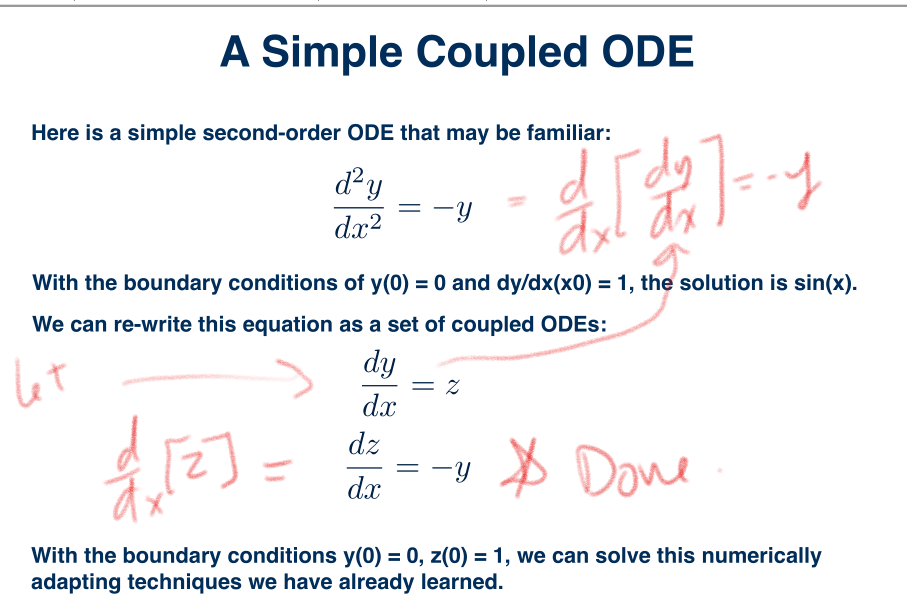

In [2]:
x = np.full((2,2), 4)
print(x)



[[4 4]
 [4 4]]


# Define our coupled derivatives to integrate 
with adaptive step size 

In [3]:
def dydx(x,y): 
    
    #set the derivatives 
    
    #our equation is d^2y/dx^2 = -y 
    
    #so we can write 
    #dydx = z 
    #dzdx = -y
    
    #we will set y = y[0]
    #we will set z = y[1]
    
    #declare an array 
    y_derivs = np.zeros(2) #array with 2 elements 
    
    #set dydx = z 
    y_derivs[0] =  y[1] 
    
    #set dzdx = -y
    y_derivs[1] = -1*y[0]
    
    #here we have to return an array 
    return y_derivs 

# Define the 4th order RK method - Core 
with multiple variables 

chaang cor cash car 

In [4]:
def rk4_mv_core(dydx, xi, yi, nv, h): 
    
    #nv is number of varaiables desired 
    
    #declare k? arrays   ... here ? means something..? ??? 
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    
    #define x at 1/2 step
    x_ipoh = xi + 0.5*h  #x plus i plus one half step 
    
    #define x at 1 step 
    x_ipo = xi + h       #x plus i plus one step 
    
    #declare a temp y array 
    y_temp = np.zeros(nv)  #tempoary 
    
    #get k1 values,
    y_derivs = dydx(xi,yi)
    k1[:] = h*y_derivs[:]  #computed at the left, and start 
    
    #get k2 values 
    y_temp[:] = yi[:] + 0.5*k1[:]  #estimate using left side 
    y_derivs = dydx(x_ipoh, y_temp) #recompute derivatives 
    k2[:] = h*y_derivs[:]
    
    #get k3 values 
    y_temp[:] = yi[:] + 0.5*k2[:] #computing mid point with derv at mid
    y_derivs = dydx(x_ipoh, y_temp) #these are all estimates 
    k3[:] = h*y_derivs[:]
    
    #get k4 values 
    y_temp[:] = yi[:] + k3[:]  #uses a full step for y at the end 
    y_derivs = dydx(x_ipo, y_temp) #of the interval 
    k4[:] = h*y_derivs[:]
    
    #advance y by a step h 
    yipo = yi + (k1 + 2*k2 + 2*k3 +k4)/6.   #neeed to compute ipo and ipo* ---here the b1k1 ...etc? 
    
    #this advances us one step 
    
    return yipo #must return yipo* to use as error estimate 

# Define an adaptive step size driver for RK4 

In [5]:
def rk4_mv_ad(dydx, x_i, y_i, nv, h, tol): 
    
    #given a step we will see to adjust, or take the same step 
    
    #define safety scale 
    SAFETY    = 0.9 #satisfies the error tolerance, smaller
    H_NEW_FAC = 2.0 #larger 
    
    #set a max number of iterations 
    imax = 10_000
    
    #set an iteratoin variable 
    i = 0 
    
    #create an error 
    Delta = np.full(nv,2*tol)
    
    #remember the step 
    
    h_step = h #actual step 
    
    #adjust step 
    while (Delta.max()/tol > 1.0): 
        
        #estimate our error by taking one step of size h ----only one line, of the y and y * 
        #vs. two steps of size h/2 
        
        y_2 = rk4_mv_core(dydx, x_i, y_i, nv, h_step) #fist large step from the end of the inverval 
        y_1 = rk4_mv_core(dydx, x_i, y_i, nv, 0.5*h_step) 
        y_11 = rk4_mv_core(dydx, x_i+0.5*h_step, y_1, nv, 0.5*h_step)
        
        #compute an error 
        Delta = np.fabs(y_2 - y_11)  #----------dif from the two values 
        
        
        #if the error is too large, take a smaller step 
        
        if Delta.max()/tol > 1.0:
            
            #our error is too large, decrease the step 
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
            
        #check iteration 
        if i >= imax: 
            print("Too many iterations in rk4_mv_ad()")
            raise StopIteration('Ending after i = ', i )
            
        #iterate 
        i += 1 
        
    #next time, try to take a bigger step 
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    #next step 
    
    #RETURN the answer, a new step, and the step we actually took 

    return y_2, h_new, h_step


#explain the steps, h_step is the one we took and evaluated 

# Define a wrapper for RK4

In [6]:
def rk4_mv(dydx, a, b, y_a, tol):  
    #dfdx is the derivative wrt x 
    #a is the lower bound 
    #b is the upper 
    #y_a are the boundary conditions 
    #tol is the tolerance for the integrating y 
    
    # define our starting step 
    xi = a 
    yi = y_a.copy()
    
    #an initial step size == make very small
    h = 1.0e-4 * (b-a)
    
    #set a maximum number of iterations 
    imax = 10_000
    
    #set a iteration variable 
    i = 0 
    
    #set a number of coupled odes to the 
    #size of y_a 
    
    nv = len(y_a)
    
    
    #set the inital conditions, what is np.ful 
    x = np.full(1,a) 
    y = np.full((1, nv), y_a)
    
    #set a flag 
    flag = 1
    
    #loop untl we reach the right side 
    while flag: 
        
        #calcullate y_i+1 
        yi_new, h_new, h_step = rk4_mv_ad(dydx, xi, yi, nv, h, tol) #return ynew h hstep 
        
        #update the step 
        h = h_new
        
        #prevent an overshot 
        if xi+h_step > b:
            
            #take a smaller step 
            h = b-xi 
            
            #recalculate y_i+1
            
            yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
            
            #break
            flag = 0 
        #update values 
        xi += h_step
        yi[:] = yi_new[:]
    
        #add the step to the arrays 
    
        x = np.append(x,xi)
        
    
        y_new = np.zeros((len(x),nv))
        
        y_new[0:len(x)-1,:] = y 
        
        y_new[-1,:] = yi[:]
        
        del y 
        
        y = y_new
    
        #prevent too many iterations 
        if i >= imax: 
            print("Max iterations reached")
            raise StopIteration("Iteration number = ", i )
        
        
        #iterate 
        i += 1 
    
        #output some info 
        s = 'i=  %3d \t x = %9.8f \t h = %9.8f \t b = %9.8f' % (i, xi, h_step, b)
        print(s)
    
        #break if new xi is ==b 
        if xi == b: 
            flag = 0 
            
    return x, y
        
    

# Perform the integration 

In [7]:
a = 0.0
b = 2.0 *np.pi 

y_0 = np.zeros(2)  #y_0 = [0,1] intial values? 

y_0[0] = 0.0
y_0[1] = 1.0

nv = 2 #why are there only 2 number of variables  [z, -y]????

tolerance = 1.0e-6

#perform the integration 
x,y = rk4_mv(dydx,a,b, y_0, tolerance)  #wrapper - ddx organizer, a,b values? 
#y = rk4_mv(dydx,a,b, y_0, tolerance) need it to be x,y as a list? 

i=    1 	 x = 0.00062832 	 h = 0.00062832 	 b = 6.28318531
i=    2 	 x = 0.00188496 	 h = 0.00125664 	 b = 6.28318531
i=    3 	 x = 0.00439823 	 h = 0.00251327 	 b = 6.28318531
i=    4 	 x = 0.00942478 	 h = 0.00502655 	 b = 6.28318531
i=    5 	 x = 0.01947787 	 h = 0.01005310 	 b = 6.28318531
i=    6 	 x = 0.03958407 	 h = 0.02010619 	 b = 6.28318531
i=    7 	 x = 0.07979645 	 h = 0.04021239 	 b = 6.28318531
i=    8 	 x = 0.16022123 	 h = 0.08042477 	 b = 6.28318531
i=    9 	 x = 0.32107077 	 h = 0.16084954 	 b = 6.28318531
i=   10 	 x = 0.46816761 	 h = 0.14709684 	 b = 6.28318531
i=   11 	 x = 0.60535502 	 h = 0.13718741 	 b = 6.28318531
i=   12 	 x = 0.74522296 	 h = 0.13986794 	 b = 6.28318531
i=   13 	 x = 0.88873209 	 h = 0.14350913 	 b = 6.28318531
i=   14 	 x = 1.02700188 	 h = 0.13826979 	 b = 6.28318531
i=   15 	 x = 1.16350434 	 h = 0.13650247 	 b = 6.28318531
i=   16 	 x = 1.29828215 	 h = 0.13477781 	 b = 6.28318531
i=   17 	 x = 1.43207856 	 h = 0.13379641 	 b = 6.283185

# Plot the result 


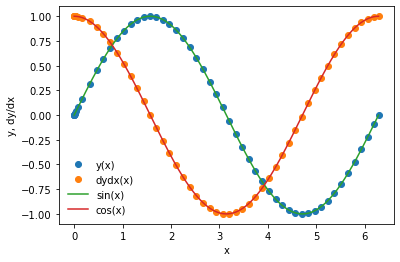

In [8]:
plt.plot(x,y[:,0], 'o', label ="y(x)")
plt.plot(x,y[:,1], 'o', label ="dydx(x)")
xx = np.linspace(0,2.0*np.pi, 1_000)
plt.plot(xx, np.sin(xx), label ='sin(x)')
plt.plot(xx, np.cos(xx), label ='cos(x)')
plt.xlabel('x')
plt.ylabel('y, dy/dx')
plt.legend(frameon = False)


# Plot the error 
the error will exceed our tolerance 


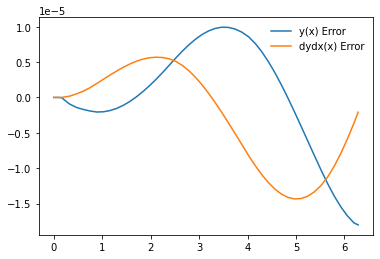

In [9]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0]-sine)
dydx_error = (y[:,1] - cosine)

plt.plot(x,y_error, label = 'y(x) Error')
plt.plot(x, dydx_error, label = 'dydx(x) Error')
plt. legend(frameon = False)

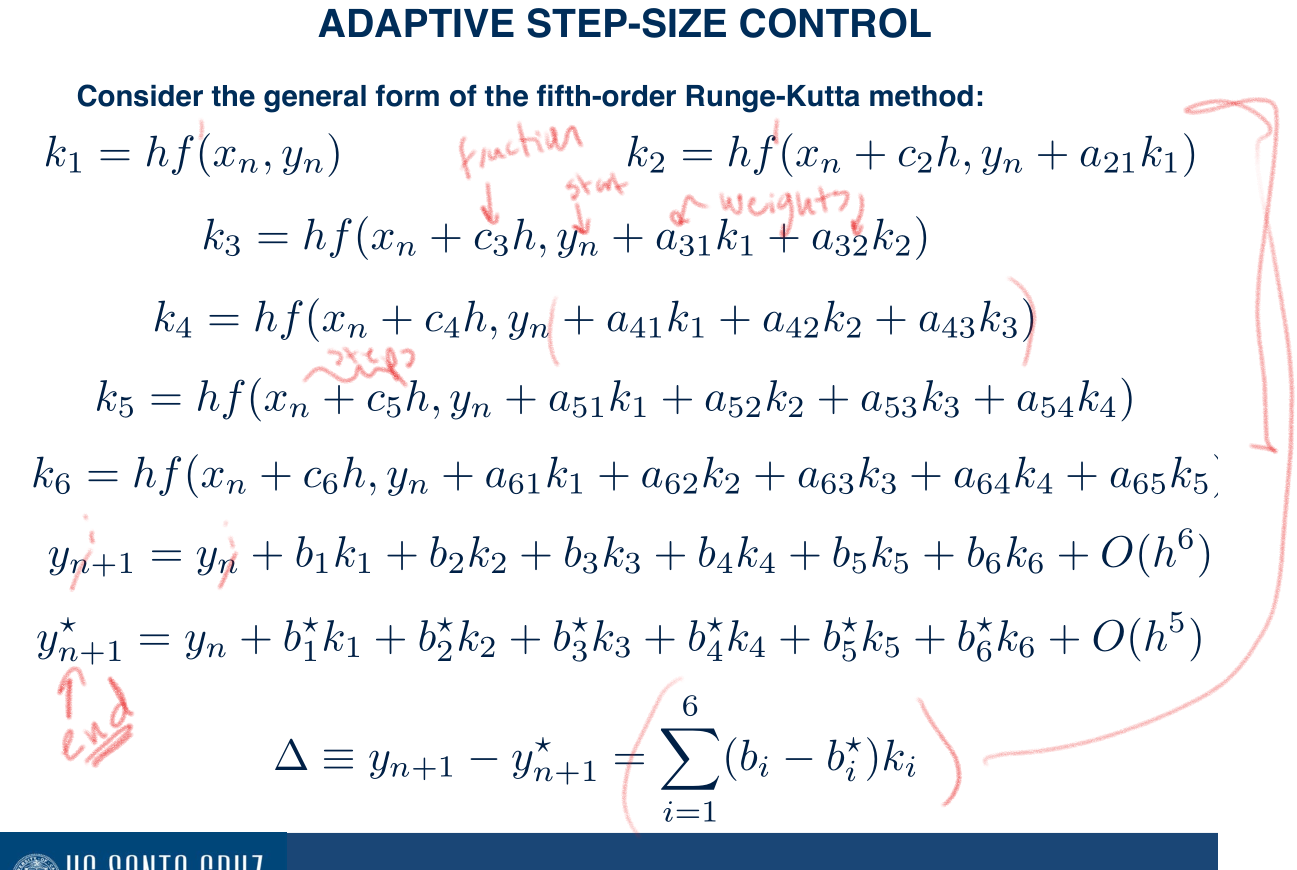


y end point n*+1 